In [ ]:
# importing the libraries
import pandas as pd
import numpy as np

# for reading and displaying images
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

In [ ]:
## Importing and normalize the dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
## Extracting label classes (to be used for calculating test data performance for each class)
classes=trainset.classes

In [ ]:
## checking class count in the whole training data (to ensure that later on, when a validation dataset is separated from the training data, the percentage in each class
#does not differ to much from the original)
class_count = {}
for _, index in trainset:
    label = classes[index]
    if label not in class_count:
        class_count[label] = 0
    class_count[label] += 1
class_count

{'frog': 5000,
 'truck': 5000,
 'deer': 5000,
 'automobile': 5000,
 'bird': 5000,
 'horse': 5000,
 'ship': 5000,
 'cat': 5000,
 'dog': 5000,
 'airplane': 5000}

In [ ]:
## separating training data to validation and training set (validation size is 5,000, training size is 45,000)
torch.manual_seed(43)
val_size = 5000
train_size = len(trainset) - val_size
trainset, valset = torch.utils.data.dataset.random_split(trainset, [train_size, val_size])

In [ ]:
## class count for the training data
class_count = {}
for _, index in trainset:
    label = classes[index]
    if label not in class_count:
        class_count[label] = 0
    class_count[label] += 1
class_count

{'frog': 4480,
 'deer': 4506,
 'horse': 4502,
 'automobile': 4528,
 'dog': 4490,
 'truck': 4520,
 'cat': 4466,
 'bird': 4502,
 'airplane': 4495,
 'ship': 4511}

In [ ]:
## class count for validation data, and the data has been separated well, no class appears too frequent or not frequent enough
class_count = {}
for _, index in valset:
    label = classes[index]
    if label not in class_count:
        class_count[label] = 0
    class_count[label] += 1
class_count

{'horse': 498,
 'truck': 480,
 'ship': 489,
 'dog': 510,
 'deer': 494,
 'airplane': 505,
 'automobile': 472,
 'frog': 520,
 'cat': 534,
 'bird': 498}

In [ ]:
## passing the data through DataLoader (training batch size is 32)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=len(valset), num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=len(testset), num_workers=2)

In [ ]:
# accuracy calculating function to compute accuracy
def accuracy(predictions, labels):
    classes = torch.argmax(predictions, dim=1)
    return torch.mean((classes == labels).float())


## Running the model in GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
## Importing function to build a CNN
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [ ]:
## Function for training process, the functions takes in number of epoch, and plot the training process
# This function also include early stopping to help with efficiency

def train_cnn(model,epoch_num,early_stopping,optimizer,criterion,PATH,out_model,plot=True):
  ## Transferring the model to GPU
  model.to(device)
  out_model.to(device)

  ## Initialize variables to keep track of the training process
  best_val_acc=0
  runs=0
  train_loss_list=[]
  train_acc_list=[]
  val_loss_list=[]
  val_acc_list=[]

  # loop over the dataset multiple times
  for epoch in range(epoch_num):  
    cur_epoch=epoch+1
    running_loss = 0.0
    running_acc=0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs and transfer them to gpu
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # calculating training statistics
        running_loss += loss.item()
        running_acc+=accuracy(outputs,labels)
    # Calculating training statistics for a whole epoch
    train_loss=running_loss/len(trainloader)
    train_acc=running_acc.item()/len(trainloader)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    

    ## Evaluation on the validation data, same process as the training data, but without any backpropagation and optimization
    with torch.no_grad():
        for x_val, y_val in valloader:
            val_losses=0
            val_acc=0
            x_val = x_val.to(device)
            y_val = y_val.to(device)
            model.eval()
            yhat = model(x_val)
            val_acc+=accuracy(yhat,y_val).item()
            val_losses+=criterion(yhat, y_val).item()
            
        val_acc_list.append(val_acc)
        val_loss_list.append(val_losses)
    runs+=1

    #printing results
    print(f"epoch {epoch+1} training loss={round(train_loss,3)}, training accuracy={round(train_acc,3)}, validation loss= {round(val_losses,3)}, validation accuracy={round(val_acc,3)}")
    
    ## early stopping, also I attempted to save the best model during training to return it as output, but
    #it fails, so in the end, I use the model from the last epoch
    
    
    if val_acc>best_val_acc:
        runs=0
        best_val_acc=val_acc
        torch.save(model.state_dict(),PATH)
    if runs==early_stopping and runs <epoch_num:
        
        print('stopped early')
        break

  ## plotting the training curve   
  if plot:
    plt.plot(range(1,cur_epoch+1), train_acc_list, 'g', range(1,cur_epoch+1), val_acc_list, 'r')
    plt.legend(['training accuracy','validation accuracy'])
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.show()

    plt.plot(range(1,cur_epoch+1), train_loss_list, 'g', range(1,cur_epoch+1), val_loss_list, 'r')
    plt.legend(['training loss','validation loss'])
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.show()
    out_model=out_model.load_state_dict(torch.load(PATH))


  ## returning the best model during training, but I found out that this did not work properly, so I could only used the model from the last epoch  
  return out_model

  


In [ ]:
## Baseline model will be the LeNet, with 2 convolutional layer and 1 fully connected layer before returning the prediction
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        self.fc1 = nn.Linear(16 * 5 * 5, 100)
        self.fc2 = nn.Linear(100, 10)
        

    def forward(self, x):
        x=  self.conv1(x)
        x = self.pool(F.relu(x))
        x=  self.conv2(x)
        x = self.pool(F.relu(x))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x



PATH0='model0.pth'

In [ ]:
# calling model, loss function and optimizer
model0=LeNet()
out_model0=LeNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model0.parameters(), lr=0.001, momentum=0.9)

epoch 1 training loss=2.105, training accuracy=0.219, validation loss= 1.844, validation accuracy=0.343
epoch 2 training loss=1.675, training accuracy=0.39, validation loss= 1.586, validation accuracy=0.424
epoch 3 training loss=1.514, training accuracy=0.451, validation loss= 1.473, validation accuracy=0.477
epoch 4 training loss=1.426, training accuracy=0.484, validation loss= 1.431, validation accuracy=0.491
epoch 5 training loss=1.343, training accuracy=0.517, validation loss= 1.337, validation accuracy=0.531
epoch 6 training loss=1.279, training accuracy=0.543, validation loss= 1.325, validation accuracy=0.528
epoch 7 training loss=1.229, training accuracy=0.56, validation loss= 1.262, validation accuracy=0.56
epoch 8 training loss=1.183, training accuracy=0.58, validation loss= 1.245, validation accuracy=0.558
epoch 9 training loss=1.149, training accuracy=0.592, validation loss= 1.212, validation accuracy=0.577
epoch 10 training loss=1.115, training accuracy=0.604, validation lo

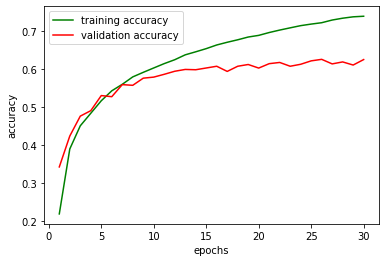

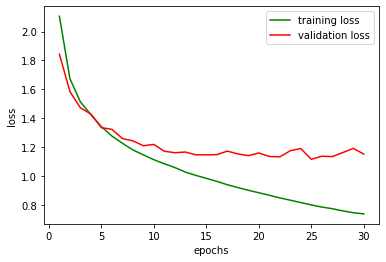

In [ ]:
#training the model
out_model0=train_cnn(model0,30, 6, optimizer,criterion,PATH0,out_model0)

In [ ]:
# LeNet but with batch normalization

class Net1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.bn1=nn.BatchNorm2d(6)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.bn2=nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(16 * 5 * 5, 100)
        self.fc2 = nn.Linear(100, 10)
        

    def forward(self, x):
        x=  self.conv1(x)
        x = self.pool(F.relu(self.bn1(x)))
        x=  self.conv2(x)
        x = self.pool(F.relu(self.bn2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x



PATH1='model1.pth'

In [ ]:

model1=Net1()
out_model1=Net1()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model1.parameters(), lr=0.001, momentum=0.9)

epoch 1 training loss=1.691, training accuracy=0.386, validation loss= 1.441, validation accuracy=0.482
epoch 2 training loss=1.363, training accuracy=0.51, validation loss= 1.327, validation accuracy=0.527
epoch 3 training loss=1.243, training accuracy=0.558, validation loss= 1.243, validation accuracy=0.56
epoch 4 training loss=1.167, training accuracy=0.583, validation loss= 1.211, validation accuracy=0.575
epoch 5 training loss=1.105, training accuracy=0.609, validation loss= 1.176, validation accuracy=0.589
epoch 6 training loss=1.055, training accuracy=0.629, validation loss= 1.168, validation accuracy=0.583
epoch 7 training loss=1.009, training accuracy=0.645, validation loss= 1.101, validation accuracy=0.615
epoch 8 training loss=0.966, training accuracy=0.66, validation loss= 1.083, validation accuracy=0.621
epoch 9 training loss=0.934, training accuracy=0.672, validation loss= 1.099, validation accuracy=0.617
epoch 10 training loss=0.894, training accuracy=0.684, validation l

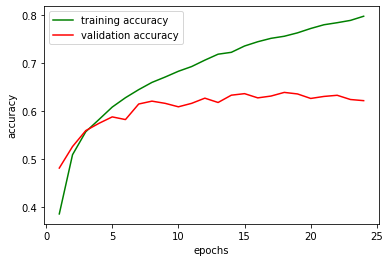

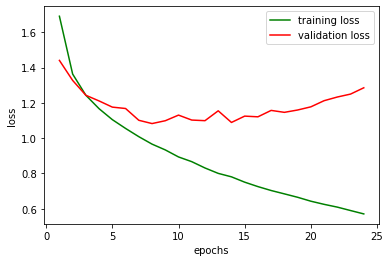

In [ ]:
out_model1=train_cnn(model1,30, 6, optimizer,criterion,PATH1,out_model1)

In [ ]:
## LeNet but with padding (no batch normalization)

class Net2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, stride=1,padding=1)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3, stride=1,padding=1)
        
        self.fc1 = nn.Linear(16 * 8 * 8, 100)
        self.fc2 = nn.Linear(100, 10)
        

    def forward(self, x):
        
        x = self.pool(F.relu(self.conv1(x)))
        
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [ ]:
model2=Net2()
out_model2=Net2()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model2.parameters(), lr=0.001, momentum=0.9)

In [ ]:
PATH2='model2.pth'

epoch 1 training loss=2.061, training accuracy=0.258, validation loss= 1.824, validation accuracy=0.352
epoch 2 training loss=1.63, training accuracy=0.417, validation loss= 1.518, validation accuracy=0.451
epoch 3 training loss=1.443, training accuracy=0.48, validation loss= 1.41, validation accuracy=0.504
epoch 4 training loss=1.344, training accuracy=0.519, validation loss= 1.351, validation accuracy=0.516
epoch 5 training loss=1.272, training accuracy=0.549, validation loss= 1.284, validation accuracy=0.542
epoch 6 training loss=1.21, training accuracy=0.571, validation loss= 1.254, validation accuracy=0.548
epoch 7 training loss=1.15, training accuracy=0.592, validation loss= 1.215, validation accuracy=0.568
epoch 8 training loss=1.098, training accuracy=0.612, validation loss= 1.212, validation accuracy=0.573
epoch 9 training loss=1.049, training accuracy=0.628, validation loss= 1.156, validation accuracy=0.583
epoch 10 training loss=1.01, training accuracy=0.645, validation loss

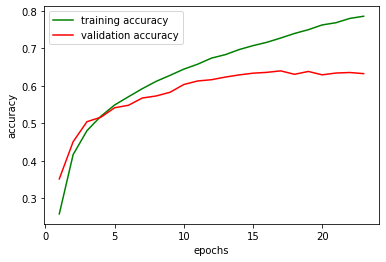

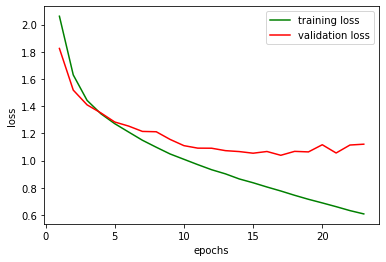

In [ ]:
out_model2=train_cnn(model2,30, 6, optimizer,criterion,PATH2,out_model2)

In [ ]:
## LeNet with both batch norm and zero padding

class Net3(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, stride=1,padding=1)
        self.bn1=nn.BatchNorm2d(6)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3, stride=1,padding=1)
        self.bn2=nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(16 * 8 * 8, 100)
        self.fc2 = nn.Linear(100, 10)
        

    def forward(self, x):
        x=  self.conv1(x)
        x = self.pool(F.relu(self.bn1(x)))
        x=  self.conv2(x)
        x = self.pool(F.relu(self.bn2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x



PATH3='model3.pth'

In [ ]:
model3=Net3()
out_model3=Net3()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model3.parameters(), lr=0.001, momentum=0.9)

epoch 1 training loss=1.597, training accuracy=0.427, validation loss= 1.377, validation accuracy=0.493
epoch 2 training loss=1.277, training accuracy=0.544, validation loss= 1.21, validation accuracy=0.56
epoch 3 training loss=1.135, training accuracy=0.598, validation loss= 1.146, validation accuracy=0.583
epoch 4 training loss=1.043, training accuracy=0.63, validation loss= 1.094, validation accuracy=0.612
epoch 5 training loss=0.971, training accuracy=0.655, validation loss= 1.058, validation accuracy=0.621
epoch 6 training loss=0.912, training accuracy=0.68, validation loss= 1.081, validation accuracy=0.635
epoch 7 training loss=0.849, training accuracy=0.701, validation loss= 1.074, validation accuracy=0.623
epoch 8 training loss=0.794, training accuracy=0.718, validation loss= 1.056, validation accuracy=0.64
epoch 9 training loss=0.746, training accuracy=0.737, validation loss= 1.072, validation accuracy=0.638
epoch 10 training loss=0.697, training accuracy=0.754, validation los

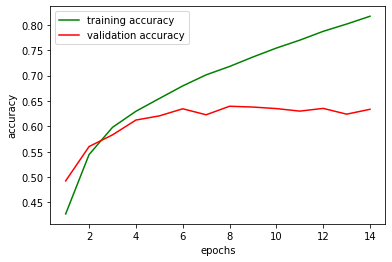

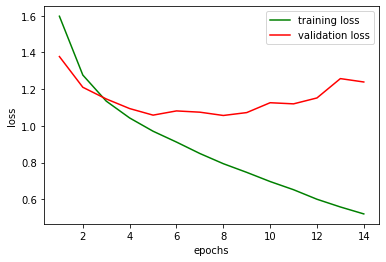

In [ ]:
out_model3=train_cnn(model3,30, 6, optimizer,criterion,PATH3,out_model3)

In [ ]:
## Increasing the depth of each convolutional layer of the LeNet (layer 1 is now 16 in depth, layer 2 is 32)

class Net4(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, stride=1,padding=1)
        self.bn1=nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, stride=1,padding=1)
        self.bn2=nn.BatchNorm2d(32)
        self.fc1 = nn.Linear(32 * 8 * 8, 100)
        self.fc2 = nn.Linear(100, 10)
        

    def forward(self, x):
        x=  self.conv1(x)
        x = self.pool(F.relu(self.bn1(x)))
        x=  self.conv2(x)
        x = self.pool(F.relu(self.bn2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x



PATH4='model4.pth'


model4 = Net4()
out_model4=Net4()
print(model4)

Net4(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=2048, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = SGD(model4.parameters(), lr=0.001, momentum=0.09)

In [ ]:
PATH4='model4.pth'

epoch 1 training loss=1.911, training accuracy=0.341, validation loss= 1.674, validation accuracy=0.418
epoch 2 training loss=1.511, training accuracy=0.467, validation loss= 1.444, validation accuracy=0.486
epoch 3 training loss=1.365, training accuracy=0.518, validation loss= 1.372, validation accuracy=0.507
epoch 4 training loss=1.276, training accuracy=0.55, validation loss= 1.294, validation accuracy=0.553
epoch 5 training loss=1.21, training accuracy=0.575, validation loss= 1.364, validation accuracy=0.527
epoch 6 training loss=1.161, training accuracy=0.592, validation loss= 1.236, validation accuracy=0.573
epoch 7 training loss=1.119, training accuracy=0.609, validation loss= 1.196, validation accuracy=0.586
epoch 8 training loss=1.079, training accuracy=0.623, validation loss= 1.175, validation accuracy=0.595
epoch 9 training loss=1.044, training accuracy=0.636, validation loss= 1.165, validation accuracy=0.592
epoch 10 training loss=1.009, training accuracy=0.649, validation 

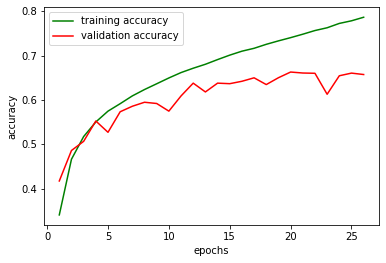

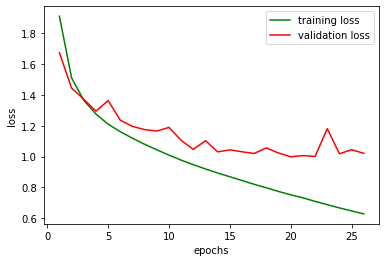

In [ ]:
out_model4=train_cnn(model4,30, 6, optimizer,criterion,PATH4,out_model4)

In [ ]:
## Increasing the depth of each convolutional layer of the previous model (layer 1 is now 32 in depth, layer 2 is 64)
class Net5(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, stride=1,padding=1)
        self.bn1=nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=1,padding=1)
        self.bn2=nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 8 * 8, 100)
        self.fc2 = nn.Linear(100, 10)
        

    def forward(self, x):
        x=  self.conv1(x)
        x = self.pool(F.relu(self.bn1(x)))
        x=  self.conv2(x)
        x = self.pool(F.relu(self.bn2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x



PATH5='model5.pth'


model5 = Net5()
out_model5=Net5()
print(model5)

Net5(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=4096, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = SGD(model5.parameters(), lr=0.001, momentum=0.09)

epoch 1 training loss=1.755, training accuracy=0.389, validation loss= 1.506, validation accuracy=0.475
epoch 2 training loss=1.367, training accuracy=0.517, validation loss= 1.364, validation accuracy=0.519
epoch 3 training loss=1.225, training accuracy=0.57, validation loss= 1.236, validation accuracy=0.562
epoch 4 training loss=1.131, training accuracy=0.605, validation loss= 1.175, validation accuracy=0.588
epoch 5 training loss=1.058, training accuracy=0.631, validation loss= 1.22, validation accuracy=0.582
epoch 6 training loss=1.002, training accuracy=0.653, validation loss= 1.088, validation accuracy=0.626
epoch 7 training loss=0.953, training accuracy=0.669, validation loss= 1.052, validation accuracy=0.631
epoch 8 training loss=0.913, training accuracy=0.684, validation loss= 1.036, validation accuracy=0.642
epoch 9 training loss=0.876, training accuracy=0.697, validation loss= 1.121, validation accuracy=0.61
epoch 10 training loss=0.841, training accuracy=0.709, validation l

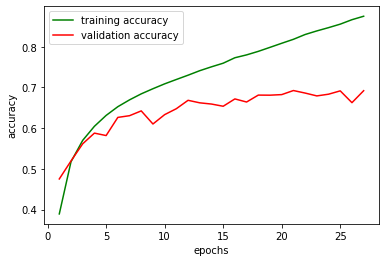

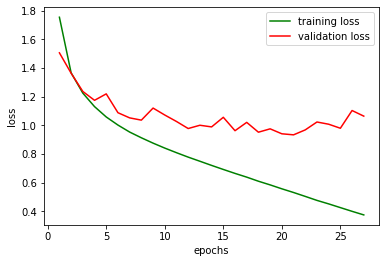

In [ ]:
out_model5=train_cnn(model5,30, 6, optimizer,criterion,PATH5,out_model5)

In [ ]:
## Increasing the depth of the network (layer 1 is now 32 in depth, layer 2 is 64 and adding a third layer with 128 in depth)
class Net6(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, stride=1,padding=1)
        self.bn1=nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=1,padding=1)
        self.bn2=nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, stride=1,padding=1)
        self.bn3=nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128 * 4 * 4, 100)
        self.fc2 = nn.Linear(100, 10)
        

    def forward(self, x):
        x=  self.conv1(x)
        x = self.pool(F.relu(self.bn1(x)))
        x=  self.conv2(x)
        x = self.pool(F.relu(self.bn2(x)))
        x=  self.conv3(x)
        x = self.pool(F.relu(self.bn3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x



PATH6='model6.pth'


model6 = Net6()
out_model6=Net6()
print(model6)

Net6(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=2048, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = SGD(model6.parameters(), lr=0.001, momentum=0.09)

epoch 1 training loss=1.82, training accuracy=0.367, validation loss= 1.583, validation accuracy=0.431
epoch 2 training loss=1.417, training accuracy=0.492, validation loss= 1.362, validation accuracy=0.501
epoch 3 training loss=1.261, training accuracy=0.553, validation loss= 1.294, validation accuracy=0.535
epoch 4 training loss=1.157, training accuracy=0.59, validation loss= 1.237, validation accuracy=0.553
epoch 5 training loss=1.073, training accuracy=0.623, validation loss= 1.154, validation accuracy=0.595
epoch 6 training loss=1.003, training accuracy=0.648, validation loss= 1.073, validation accuracy=0.618
epoch 7 training loss=0.947, training accuracy=0.669, validation loss= 1.068, validation accuracy=0.622
epoch 8 training loss=0.898, training accuracy=0.687, validation loss= 0.976, validation accuracy=0.659
epoch 9 training loss=0.857, training accuracy=0.702, validation loss= 1.055, validation accuracy=0.641
epoch 10 training loss=0.818, training accuracy=0.715, validation 

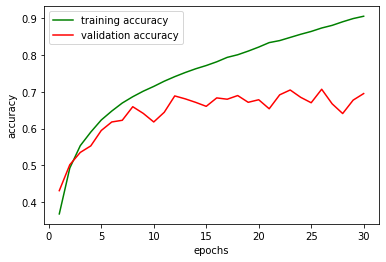

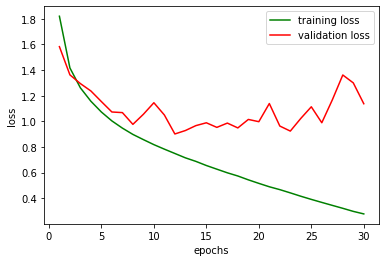

In [ ]:
out_model6=train_cnn(model6,30, 6, optimizer,criterion,PATH6,out_model6)

In [ ]:
## Another model, but increasing the learning rate

PATH7='model7.pth'


model7 = Net6()
out_model7=Net6()
criterion = nn.CrossEntropyLoss()
optimizer = SGD(model7.parameters(), lr=0.01, momentum=0.09)

epoch 1 training loss=1.326, training accuracy=0.524, validation loss= 1.281, validation accuracy=0.552
epoch 2 training loss=1.035, training accuracy=0.638, validation loss= 1.299, validation accuracy=0.57
epoch 3 training loss=0.825, training accuracy=0.708, validation loss= 1.404, validation accuracy=0.544
epoch 4 training loss=0.707, training accuracy=0.751, validation loss= 0.896, validation accuracy=0.687
epoch 5 training loss=0.604, training accuracy=0.79, validation loss= 0.76, validation accuracy=0.74
epoch 6 training loss=0.519, training accuracy=0.817, validation loss= 0.767, validation accuracy=0.744
epoch 7 training loss=0.439, training accuracy=0.847, validation loss= 0.954, validation accuracy=0.696
epoch 8 training loss=0.37, training accuracy=0.87, validation loss= 0.957, validation accuracy=0.707
epoch 9 training loss=0.316, training accuracy=0.889, validation loss= 0.849, validation accuracy=0.741
epoch 10 training loss=0.258, training accuracy=0.908, validation loss

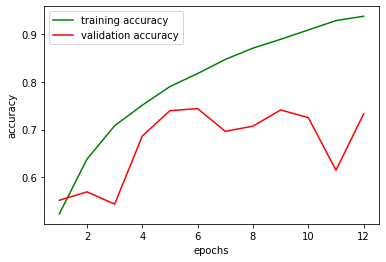

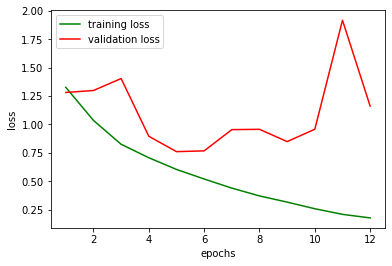

In [ ]:
out_model7=train_cnn(model7,30, 6, optimizer,criterion,PATH7,out_model7)

In [ ]:
## Increasing the depth in the fully connected layer (now has fully connected layer of depth 300 and 100, respectively, before the output layer)

class Net7(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, stride=1,padding=1)
        self.bn1=nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=1,padding=1)
        self.bn2=nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, stride=1,padding=1)
        self.bn3=nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128 * 4 * 4, 300)
        self.fc2 = nn.Linear(300, 100)
        self.fc3 = nn.Linear(100, 10)
        

    def forward(self, x):
        x=  self.conv1(x)
        x = self.pool(F.relu(self.bn1(x)))
        x=  self.conv2(x)
        x = self.pool(F.relu(self.bn2(x)))
        x=  self.conv3(x)
        x = self.pool(F.relu(self.bn3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x



PATH8='model8.pth'


model8 = Net7()
out_model8=Net7()
print(model8)

Net7(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=2048, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)


In [ ]:
## running the model with the lr=0.001
criterion = nn.CrossEntropyLoss()
optimizer = SGD(model8.parameters(), lr=0.001,momentum=0.09)

epoch 1 training loss=2.09, training accuracy=0.287, validation loss= 1.834, validation accuracy=0.379
epoch 2 training loss=1.57, training accuracy=0.436, validation loss= 1.453, validation accuracy=0.46
epoch 3 training loss=1.349, training accuracy=0.517, validation loss= 1.309, validation accuracy=0.533
epoch 4 training loss=1.22, training accuracy=0.569, validation loss= 1.294, validation accuracy=0.527
epoch 5 training loss=1.126, training accuracy=0.604, validation loss= 1.2, validation accuracy=0.57
epoch 6 training loss=1.047, training accuracy=0.633, validation loss= 1.059, validation accuracy=0.623
epoch 7 training loss=0.99, training accuracy=0.656, validation loss= 1.171, validation accuracy=0.594
epoch 8 training loss=0.938, training accuracy=0.677, validation loss= 1.113, validation accuracy=0.604
epoch 9 training loss=0.895, training accuracy=0.687, validation loss= 1.087, validation accuracy=0.616
epoch 10 training loss=0.855, training accuracy=0.703, validation loss= 

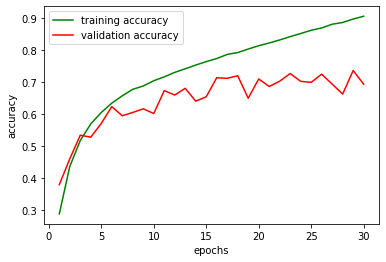

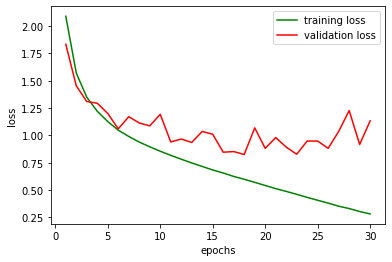

In [ ]:
out_model8=train_cnn(model8,30, 6, optimizer,criterion,PATH8,out_model8)

In [ ]:
## Increasing the learning rate
PATH9='model9.pth'


model9 = Net7()
out_model9=Net7()
print(model9)

Net7(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=2048, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = SGD(model9.parameters(), lr=0.01,momentum=0.09)

epoch 1 training loss=1.482, training accuracy=0.461, validation loss= 1.268, validation accuracy=0.552
epoch 2 training loss=1.09, training accuracy=0.613, validation loss= 1.181, validation accuracy=0.572
epoch 3 training loss=0.872, training accuracy=0.695, validation loss= 0.944, validation accuracy=0.67
epoch 4 training loss=0.731, training accuracy=0.745, validation loss= 0.87, validation accuracy=0.699
epoch 5 training loss=0.623, training accuracy=0.782, validation loss= 1.178, validation accuracy=0.617
epoch 6 training loss=0.524, training accuracy=0.814, validation loss= 0.81, validation accuracy=0.73
epoch 7 training loss=0.432, training accuracy=0.849, validation loss= 2.021, validation accuracy=0.537
epoch 8 training loss=0.359, training accuracy=0.873, validation loss= 0.843, validation accuracy=0.741
epoch 9 training loss=0.284, training accuracy=0.899, validation loss= 0.993, validation accuracy=0.72
epoch 10 training loss=0.216, training accuracy=0.923, validation loss

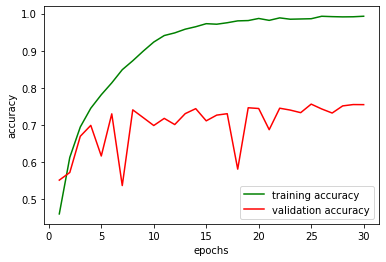

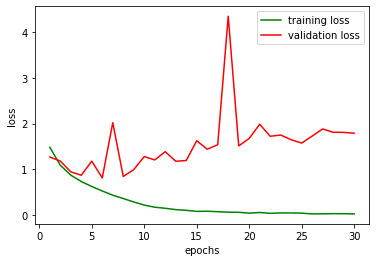

In [ ]:
out_model9=train_cnn(model9,30, 6, optimizer,criterion,PATH9,out_model9)

In [ ]:
# next model contains regularization

PATH10='model10.pth'


model10 = Net7()
out_model10=Net7()
print(model10)

Net7(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=2048, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)


In [ ]:
## testing with lasso, smaller weight decay
criterion = nn.CrossEntropyLoss()
optimizer = SGD(model10.parameters(), lr=0.001,momentum=0.09, weight_decay=1e-5)

epoch 1 training loss=2.137, training accuracy=0.272, validation loss= 1.915, validation accuracy=0.343
epoch 2 training loss=1.632, training accuracy=0.422, validation loss= 1.507, validation accuracy=0.442
epoch 3 training loss=1.377, training accuracy=0.505, validation loss= 1.37, validation accuracy=0.504
epoch 4 training loss=1.249, training accuracy=0.556, validation loss= 1.327, validation accuracy=0.525
epoch 5 training loss=1.154, training accuracy=0.594, validation loss= 1.202, validation accuracy=0.572
epoch 6 training loss=1.077, training accuracy=0.622, validation loss= 1.239, validation accuracy=0.554
epoch 7 training loss=1.011, training accuracy=0.644, validation loss= 1.495, validation accuracy=0.508
epoch 8 training loss=0.958, training accuracy=0.665, validation loss= 1.032, validation accuracy=0.636
epoch 9 training loss=0.913, training accuracy=0.68, validation loss= 1.062, validation accuracy=0.635
epoch 10 training loss=0.87, training accuracy=0.697, validation l

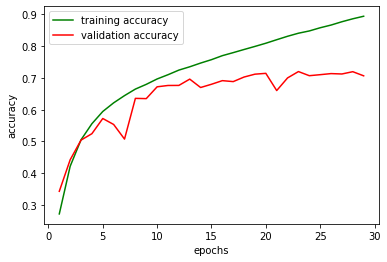

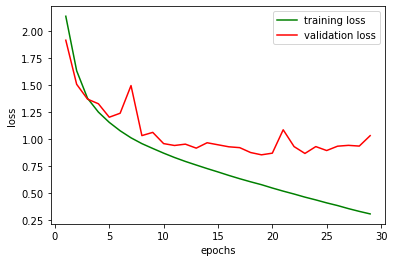

In [ ]:
out_model10=train_cnn(model10,30, 6, optimizer,criterion,PATH10,out_model10)

In [ ]:
# same model, but higher learning rate and bigger weight_decay
PATH11='model11.pth'


model11 = Net7()
out_model11=Net7()
print(model11)

Net7(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=2048, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = SGD(model11.parameters(), lr=0.01,momentum=0.09, weight_decay=1e-4)

epoch 1 training loss=1.452, training accuracy=0.474, validation loss= 1.272, validation accuracy=0.543
epoch 2 training loss=1.075, training accuracy=0.621, validation loss= 1.136, validation accuracy=0.601
epoch 3 training loss=0.859, training accuracy=0.697, validation loss= 1.26, validation accuracy=0.586
epoch 4 training loss=0.729, training accuracy=0.744, validation loss= 0.974, validation accuracy=0.672
epoch 5 training loss=0.625, training accuracy=0.781, validation loss= 0.941, validation accuracy=0.669
epoch 6 training loss=0.529, training accuracy=0.815, validation loss= 0.871, validation accuracy=0.712
epoch 7 training loss=0.443, training accuracy=0.845, validation loss= 2.134, validation accuracy=0.482
epoch 8 training loss=0.361, training accuracy=0.873, validation loss= 0.959, validation accuracy=0.715
epoch 9 training loss=0.294, training accuracy=0.897, validation loss= 0.887, validation accuracy=0.738
epoch 10 training loss=0.224, training accuracy=0.92, validation 

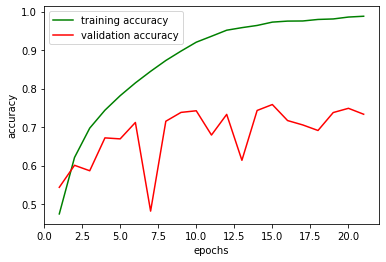

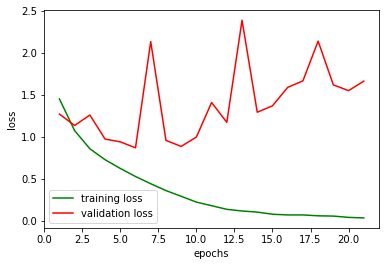

In [ ]:
out_model11=train_cnn(model11,30, 6, optimizer,criterion,PATH11,out_model11)

In [ ]:
## Same as the previous neural net structure, but with added drop out layer to increase regularization
class Net8(nn.Module):
    def __init__(self, drop_rate=0.2):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, stride=1,padding=1)
        self.bn1=nn.BatchNorm2d(32)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=1,padding=1)
        self.bn2=nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, stride=1,padding=1)
        self.bn3=nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128 * 4 * 4, 300)
        self.drop1=nn.Dropout(drop_rate)
        self.fc2 = nn.Linear(300, 100)
        self.drop2=nn.Dropout(drop_rate)
        self.fc3 = nn.Linear(100, 10)
        

    def forward(self, x):
        x=  self.conv1(x)
        x = self.pool(F.relu(self.bn1(x)))
        x=  self.conv2(x)
        x = self.pool(F.relu(self.bn2(x)))
        x=  self.conv3(x)
        x = self.pool(F.relu(self.bn3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
       
        x = F.relu(self.fc1(x))
        x=  self.drop1(x)
        x = F.relu(self.fc2(x))
        x=  self.drop2(x)
  
        x = self.fc3(x)
        
        return x

In [ ]:
# modelwith 0.01 learning rate and higher weight decay

PATH12='model12.pth'


model12 = Net8()
out_model12=Net8()
print(model12)

Net8(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=2048, out_features=300, bias=True)
  (drop1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=300, out_features=100, bias=True)
  (drop2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = SGD(model12.parameters(), lr=0.01, momentum=0.09,weight_decay=1e-4)

epoch 1 training loss=1.474, training accuracy=0.465, validation loss= 1.618, validation accuracy=0.435
epoch 2 training loss=1.082, training accuracy=0.615, validation loss= 1.3, validation accuracy=0.558
epoch 3 training loss=0.853, training accuracy=0.7, validation loss= 1.049, validation accuracy=0.639
epoch 4 training loss=0.718, training accuracy=0.747, validation loss= 0.898, validation accuracy=0.688
epoch 5 training loss=0.611, training accuracy=0.788, validation loss= 1.428, validation accuracy=0.589
epoch 6 training loss=0.514, training accuracy=0.819, validation loss= 0.92, validation accuracy=0.706
epoch 7 training loss=0.428, training accuracy=0.852, validation loss= 0.834, validation accuracy=0.742
epoch 8 training loss=0.343, training accuracy=0.881, validation loss= 0.872, validation accuracy=0.734
epoch 9 training loss=0.272, training accuracy=0.905, validation loss= 1.513, validation accuracy=0.633
epoch 10 training loss=0.219, training accuracy=0.922, validation los

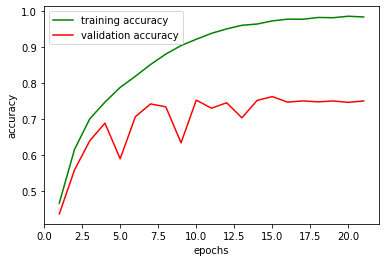

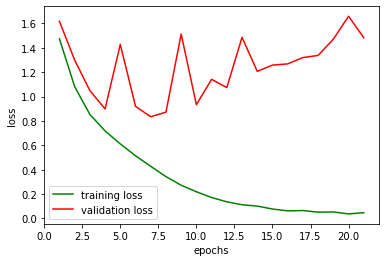

In [ ]:
## accuracy does not improved, but validation loss did not grows larger than initial loss
out_model12=train_cnn(model12,30, 6, optimizer,criterion,PATH12,out_model12)

In [ ]:
PATH13='model13.pth'


model13 = Net8()
out_model13=Net8()
print(model13)

Net8(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=2048, out_features=300, bias=True)
  (drop1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=300, out_features=100, bias=True)
  (drop2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = SGD(model13.parameters(), lr=0.001, momentum=0.09,weight_decay=1e-5)

epoch 1 training loss=2.106, training accuracy=0.262, validation loss= 1.863, validation accuracy=0.363
epoch 2 training loss=1.606, training accuracy=0.422, validation loss= 1.489, validation accuracy=0.448
epoch 3 training loss=1.392, training accuracy=0.498, validation loss= 1.398, validation accuracy=0.491
epoch 4 training loss=1.279, training accuracy=0.544, validation loss= 1.325, validation accuracy=0.529
epoch 5 training loss=1.183, training accuracy=0.582, validation loss= 1.249, validation accuracy=0.559
epoch 6 training loss=1.1, training accuracy=0.613, validation loss= 1.548, validation accuracy=0.478
epoch 7 training loss=1.029, training accuracy=0.639, validation loss= 1.125, validation accuracy=0.603
epoch 8 training loss=0.97, training accuracy=0.66, validation loss= 1.219, validation accuracy=0.58
epoch 9 training loss=0.919, training accuracy=0.68, validation loss= 1.086, validation accuracy=0.614
epoch 10 training loss=0.876, training accuracy=0.694, validation loss

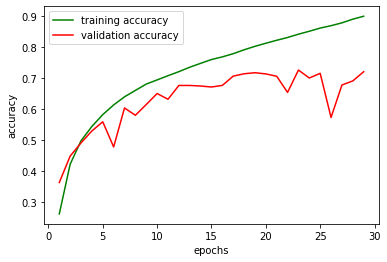

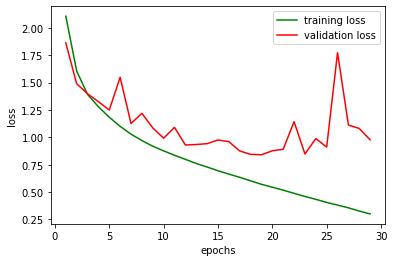

In [ ]:
out_model13=train_cnn(model13,30, 6, optimizer,criterion,PATH13,out_model13)

In [ ]:
## same as before, but now including learning rate scheduling, first schedule is reduce learning rate if validation loss has not decreased in 5 epochs, learning rate=0.01, and weight decay 1e-4
PATH14='model14.pth'


model14 = Net8()
out_model14=Net8()
print(model14)

Net8(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=2048, out_features=300, bias=True)
  (drop1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=300, out_features=100, bias=True)
  (drop2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = SGD(model14.parameters(), lr=0.01, momentum=0.09,weight_decay=1e-4)

In [ ]:
scheduler = ReduceLROnPlateau(optimizer, 'min', patience = 5)

In [ ]:
## redefine training function to include learning rate scheduling
def train_cnn_w_schedule(model,epoch_num,early_stopping,optimizer,criterion,PATH,out_model,lr_schedule,plot=True, lr_by_step=False):
  
  model.to(device)
  out_model.to(device)
  best_val_acc=0
  runs=0
  train_loss_list=[]
  train_acc_list=[]
  val_loss_list=[]
  val_acc_list=[]
  for epoch in range(epoch_num):  # loop over the dataset multiple times
    cur_epoch=epoch+1
    running_loss = 0.0
    running_acc=0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        running_acc+=accuracy(outputs,labels)
    train_loss=running_loss/len(trainloader)
    train_acc=running_acc.item()/len(trainloader)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    with torch.no_grad():
        for x_val, y_val in valloader:
            val_losses=0
            val_acc=0
            x_val = x_val.to(device)
            y_val = y_val.to(device)
            model.eval()
            yhat = model(x_val)
            
            val_losses+=criterion(yhat, y_val).item()
            val_acc+=accuracy(yhat,y_val).item()
        val_acc_list.append(val_acc)
        val_loss_list.append(val_losses)
    runs+=1
    curr_lr = optimizer.param_groups[0]['lr']
    print(f"epoch {epoch+1} training loss={round(train_loss,3)}, training accuracy={round(train_acc,3)}, validation loss= {round(val_losses,3)}, validation accuracy={round(val_acc,3)}, lr={curr_lr}")
    if lr_by_step:
      scheduler.step()
    else:
      scheduler.step(val_losses)
    if val_acc>best_val_acc:
        runs=0
        best_val_acc=val_acc
        torch.save(model.state_dict(),PATH)
    if runs==early_stopping and runs <epoch_num:
        
        print('stopped early')
        break
    
  if plot:
    plt.plot(range(1,cur_epoch+1), train_acc_list, 'g', range(1,cur_epoch+1), val_acc_list, 'r')
    plt.legend(['training accuracy','validation accuracy'])
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.show()

    plt.plot(range(1,cur_epoch+1), train_loss_list, 'g', range(1,cur_epoch+1), val_loss_list, 'r')
    plt.legend(['training loss','validation loss'])
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.show()
    out_model=out_model.load_state_dict(torch.load(PATH))
    
  return out_model

epoch 1 training loss=1.493, training accuracy=0.46, validation loss= 1.299, validation accuracy=0.533, lr=0.01
epoch 2 training loss=1.086, training accuracy=0.617, validation loss= 1.142, validation accuracy=0.593, lr=0.01
epoch 3 training loss=0.861, training accuracy=0.696, validation loss= 1.008, validation accuracy=0.649, lr=0.01
epoch 4 training loss=0.726, training accuracy=0.746, validation loss= 0.986, validation accuracy=0.673, lr=0.01
epoch 5 training loss=0.614, training accuracy=0.784, validation loss= 0.869, validation accuracy=0.705, lr=0.01
epoch 6 training loss=0.519, training accuracy=0.817, validation loss= 1.101, validation accuracy=0.654, lr=0.01
epoch 7 training loss=0.426, training accuracy=0.85, validation loss= 0.916, validation accuracy=0.712, lr=0.01
epoch 8 training loss=0.35, training accuracy=0.876, validation loss= 1.022, validation accuracy=0.697, lr=0.01
epoch 9 training loss=0.272, training accuracy=0.904, validation loss= 1.033, validation accuracy=0

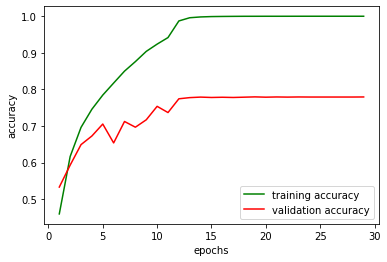

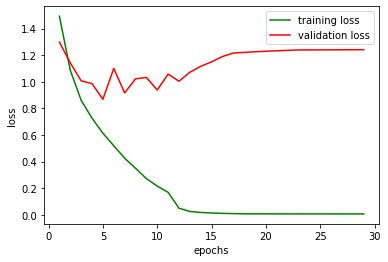

In [ ]:
## improved accuracy, but overfitting still persist
out_model14=train_cnn_w_schedule(model14,30,10,optimizer,criterion,PATH14,out_model14,scheduler)

In [ ]:
## making scheduler decrease learning rate more frequent (4 runs without decreased loss instead of 5)

PATH15='model15.pth'


model15 = Net8()
out_model15=Net8()
print(model15)

Net8(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=2048, out_features=300, bias=True)
  (drop1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=300, out_features=100, bias=True)
  (drop2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = SGD(model15.parameters(), lr=0.01, momentum=0.09,weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience = 4)


In [ ]:
PATH15='model15.pth'

epoch 1 training loss=1.492, training accuracy=0.459, validation loss= 1.308, validation accuracy=0.535, lr=0.01
epoch 2 training loss=1.086, training accuracy=0.616, validation loss= 1.148, validation accuracy=0.593, lr=0.01
epoch 3 training loss=0.862, training accuracy=0.696, validation loss= 1.066, validation accuracy=0.629, lr=0.01
epoch 4 training loss=0.726, training accuracy=0.745, validation loss= 0.965, validation accuracy=0.675, lr=0.01
epoch 5 training loss=0.614, training accuracy=0.784, validation loss= 0.872, validation accuracy=0.702, lr=0.01
epoch 6 training loss=0.518, training accuracy=0.817, validation loss= 1.557, validation accuracy=0.571, lr=0.01
epoch 7 training loss=0.427, training accuracy=0.849, validation loss= 0.889, validation accuracy=0.721, lr=0.01
epoch 8 training loss=0.347, training accuracy=0.877, validation loss= 1.231, validation accuracy=0.656, lr=0.01
epoch 9 training loss=0.272, training accuracy=0.904, validation loss= 0.943, validation accurac

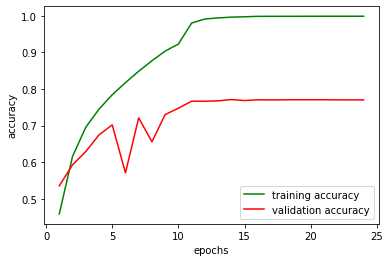

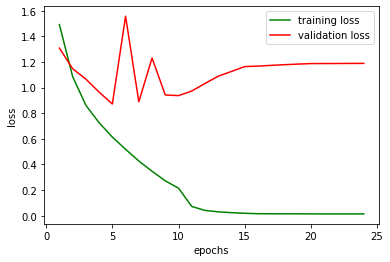

In [ ]:
## no big change compared to the previous run
out_model15=train_cnn_w_schedule(model15,30,10,optimizer,criterion,PATH15,out_model15,scheduler)

In [ ]:
## testing with learning rate scheduler that decrease learning rate after every 7 epochs 
PATH16='model16.pth'


model16 = Net8()
out_model16=Net8()
print(model16)

Net8(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=2048, out_features=300, bias=True)
  (drop1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=300, out_features=100, bias=True)
  (drop2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = SGD(model16.parameters(), lr=0.01, momentum=0.09,weight_decay=1e-4)
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

epoch 1 training loss=1.479, training accuracy=0.466, validation loss= 1.484, validation accuracy=0.466, lr=0.01
epoch 2 training loss=1.063, training accuracy=0.624, validation loss= 1.2, validation accuracy=0.585, lr=0.01
epoch 3 training loss=0.848, training accuracy=0.701, validation loss= 0.994, validation accuracy=0.659, lr=0.01
epoch 4 training loss=0.711, training accuracy=0.751, validation loss= 0.94, validation accuracy=0.682, lr=0.01
epoch 5 training loss=0.606, training accuracy=0.786, validation loss= 0.85, validation accuracy=0.715, lr=0.01
epoch 6 training loss=0.511, training accuracy=0.82, validation loss= 1.356, validation accuracy=0.584, lr=0.01
epoch 7 training loss=0.43, training accuracy=0.849, validation loss= 1.507, validation accuracy=0.576, lr=0.01
epoch 8 training loss=0.224, training accuracy=0.927, validation loss= 0.753, validation accuracy=0.77, lr=0.001
epoch 9 training loss=0.174, training accuracy=0.946, validation loss= 0.773, validation accuracy=0.77

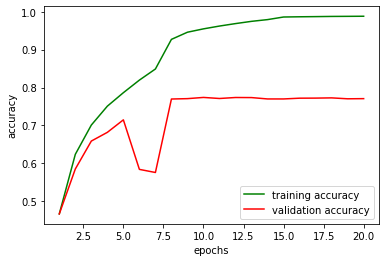

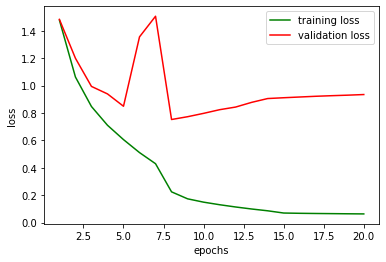

In [ ]:
## similar accuracy, and overfitting seems to be more controlled
out_model16=train_cnn_w_schedule(model16,30,10,optimizer,criterion,PATH16,out_model16,scheduler,lr_by_step=True)

In [ ]:
# Tested the same structure as before, but with adam optimizer
PATH17='model17.pth'


model17 = Net8()
out_model17=Net8()
print(model17)


Net8(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=2048, out_features=300, bias=True)
  (drop1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=300, out_features=100, bias=True)
  (drop2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)


In [ ]:
## tried with reduce on plateau 
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model17.parameters(), lr=0.001,weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience = 5)

epoch 1 training loss=1.319, training accuracy=0.518, validation loss= 1.085, validation accuracy=0.616, lr=0.001
epoch 2 training loss=0.895, training accuracy=0.684, validation loss= 0.852, validation accuracy=0.697, lr=0.001
epoch 3 training loss=0.709, training accuracy=0.751, validation loss= 0.78, validation accuracy=0.728, lr=0.001
epoch 4 training loss=0.582, training accuracy=0.797, validation loss= 0.723, validation accuracy=0.753, lr=0.001
epoch 5 training loss=0.472, training accuracy=0.834, validation loss= 0.791, validation accuracy=0.737, lr=0.001
epoch 6 training loss=0.387, training accuracy=0.864, validation loss= 0.796, validation accuracy=0.752, lr=0.001
epoch 7 training loss=0.308, training accuracy=0.891, validation loss= 0.848, validation accuracy=0.748, lr=0.001
epoch 8 training loss=0.253, training accuracy=0.911, validation loss= 0.938, validation accuracy=0.745, lr=0.001
epoch 9 training loss=0.207, training accuracy=0.928, validation loss= 0.977, validation 

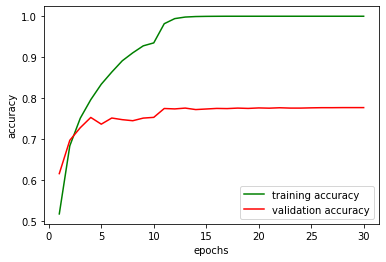

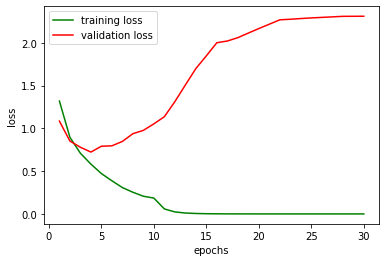

In [ ]:
## faster convergence, but worse overfitting, the final accuracy is very close
out_model17=train_cnn_w_schedule(model17,30,10,optimizer,criterion,PATH17,out_model17,scheduler)

In [ ]:
# ADAM with stronger regularization, this time decrease learning rate after every 6 epochs
PATH18='model18.pth'


model18 = Net8(0.3)
out_model18=Net8()
print(model18)

Net8(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=2048, out_features=300, bias=True)
  (drop1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=300, out_features=100, bias=True)
  (drop2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model18.parameters(), lr=0.001,weight_decay=1e-4)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

epoch 1 training loss=1.418, training accuracy=0.482, validation loss= 1.094, validation accuracy=0.602, lr=0.001
epoch 2 training loss=0.929, training accuracy=0.672, validation loss= 0.892, validation accuracy=0.692, lr=0.001
epoch 3 training loss=0.73, training accuracy=0.744, validation loss= 0.804, validation accuracy=0.72, lr=0.001
epoch 4 training loss=0.606, training accuracy=0.789, validation loss= 0.765, validation accuracy=0.745, lr=0.001
epoch 5 training loss=0.505, training accuracy=0.824, validation loss= 0.759, validation accuracy=0.747, lr=0.001
epoch 6 training loss=0.421, training accuracy=0.852, validation loss= 0.772, validation accuracy=0.751, lr=0.001
epoch 7 training loss=0.206, training accuracy=0.931, validation loss= 0.764, validation accuracy=0.785, lr=0.0001
epoch 8 training loss=0.148, training accuracy=0.952, validation loss= 0.828, validation accuracy=0.782, lr=0.0001
epoch 9 training loss=0.114, training accuracy=0.964, validation loss= 0.874, validation

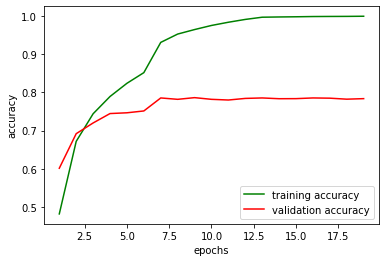

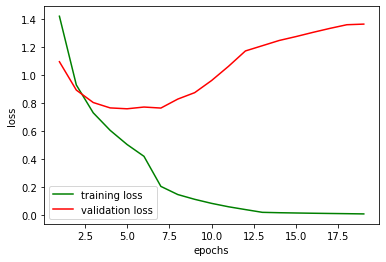

In [ ]:
## slightly improved accuracy, and more controlled overfitting
out_model18=train_cnn_w_schedule(model18,30,10,optimizer,criterion,PATH18,out_model18,scheduler,lr_by_step=True)

In [ ]:
# ADAM with increased regularization again and reduce learn rate on plateau again
PATH19='model19.pth'


model19 = Net8(0.3)
out_model19=Net8()
print(model19)

Net8(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=2048, out_features=300, bias=True)
  (drop1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=300, out_features=100, bias=True)
  (drop2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model19.parameters(), lr=0.001,weight_decay=1e-3)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience = 3)

epoch 1 training loss=1.411, training accuracy=0.488, validation loss= 1.066, validation accuracy=0.618, lr=0.001
epoch 2 training loss=0.948, training accuracy=0.666, validation loss= 0.934, validation accuracy=0.669, lr=0.001
epoch 3 training loss=0.775, training accuracy=0.73, validation loss= 0.827, validation accuracy=0.713, lr=0.001
epoch 4 training loss=0.684, training accuracy=0.761, validation loss= 0.821, validation accuracy=0.715, lr=0.001
epoch 5 training loss=0.617, training accuracy=0.785, validation loss= 0.712, validation accuracy=0.756, lr=0.001
epoch 6 training loss=0.557, training accuracy=0.807, validation loss= 0.726, validation accuracy=0.752, lr=0.001
epoch 7 training loss=0.51, training accuracy=0.823, validation loss= 0.757, validation accuracy=0.745, lr=0.001
epoch 8 training loss=0.478, training accuracy=0.833, validation loss= 0.728, validation accuracy=0.752, lr=0.001
epoch 9 training loss=0.446, training accuracy=0.845, validation loss= 0.706, validation a

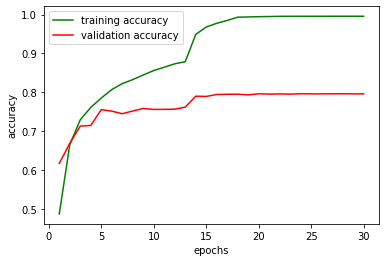

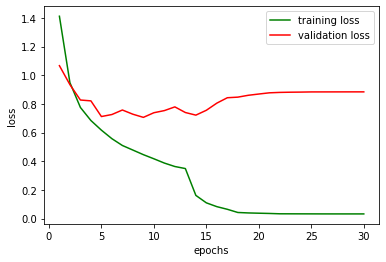

In [ ]:
## improved accuracy, and validation loss at the later epoch does not match or surpass loss at the start-> best model so far
out_model19=train_cnn_w_schedule(model19,30,10,optimizer,criterion,PATH19,out_model19,scheduler)

In [ ]:
## Compared the best developed model with a model similar to VGG
## this ones contains 3 stacks of Convolutional layer (each stack contains 2 convolution layers, the size in order for each stack is 32, 64 and 128 (e.g first stack contains 2 layers
# with depth of 32 in each layer))

class VggStyleNet(nn.Module):
    def __init__(self, drop_rate=0.2):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, stride=1,padding=1)
        self.bn1=nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, 3, stride=1,padding=1)
        self.bn2=nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.conv3 = nn.Conv2d(32, 64, 3, stride=1,padding=1)
        self.bn3=nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, 3, stride=1,padding=1)
        self.bn4=nn.BatchNorm2d(64)
        
        self.conv5 = nn.Conv2d(64, 128, 3, stride=1,padding=1)
        self.bn5=nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, 3, stride=1,padding=1)
        self.bn6=nn.BatchNorm2d(128)
        
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.drop1=nn.Dropout(drop_rate)
        
        self.fc2 = nn.Linear(256, 128)
        self.drop2=nn.Dropout(drop_rate)
        self.fc3 = nn.Linear(128,10)
        

    def forward(self, x):
        x =  self.conv1(x)
        x =  self.conv2(F.relu(self.bn1(x)))
        x = self.pool(F.relu(self.bn2(x)))
        
        x =  self.conv3(x)
        x =  self.conv4(F.relu(self.bn3(x)))
        x = self.pool(F.relu(self.bn4(x))) 
        
        x =  self.conv5(x)
        x =  self.conv6(F.relu(self.bn5(x)))
        x = self.pool(F.relu(self.bn6(x))) 
        
        x = torch.flatten(x, 1) # flatten all dimensions except batch
       
        x = F.relu(self.fc1(x))
        x=  self.drop1(x)
        x = F.relu(self.fc2(x))
        x=  self.drop2(x)
        x = self.fc3(x)
        
        return x

In [ ]:
## drop out rate is 0.2
PATH21='vgg.pth'


vgg_style = VggStyleNet(0.2)
out_vggstyle=VggStyleNet(0.2)
print(vgg_style)

VggStyleNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=

In [ ]:
## trained with reduce learning rate on plateau scheduler and weight decay
criterion = nn.CrossEntropyLoss()
optimizer = Adam(vgg_style.parameters(), lr=0.001, weight_decay=1e-3)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience = 3)

epoch 1 training loss=1.366, training accuracy=0.502, validation loss= 1.276, validation accuracy=0.547, lr=0.001
epoch 2 training loss=0.952, training accuracy=0.661, validation loss= 0.89, validation accuracy=0.693, lr=0.001
epoch 3 training loss=0.781, training accuracy=0.725, validation loss= 0.771, validation accuracy=0.734, lr=0.001
epoch 4 training loss=0.694, training accuracy=0.759, validation loss= 0.686, validation accuracy=0.76, lr=0.001
epoch 5 training loss=0.633, training accuracy=0.779, validation loss= 0.673, validation accuracy=0.767, lr=0.001
epoch 6 training loss=0.585, training accuracy=0.796, validation loss= 0.635, validation accuracy=0.782, lr=0.001
epoch 7 training loss=0.547, training accuracy=0.808, validation loss= 0.646, validation accuracy=0.778, lr=0.001
epoch 8 training loss=0.509, training accuracy=0.822, validation loss= 0.693, validation accuracy=0.764, lr=0.001
epoch 9 training loss=0.484, training accuracy=0.832, validation loss= 0.631, validation a

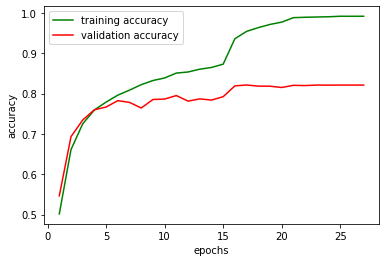

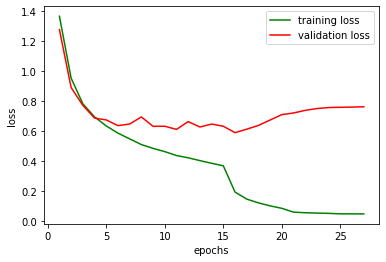

In [ ]:
## This achieved an improved validation accuracy (about 3%) and less severe overfitting compared to the best model
out_vggstyle=train_cnn_w_schedule(vgg_style,30,10,optimizer,criterion,PATH21,out_vggstyle,scheduler)

In [ ]:
# checking on test data

In [ ]:
## function to calculate overall test accuracy and accuracy for each classes
def test_acc(out_model,classes=classes,testloader=testloader):

  correct_pred = {classname: 0 for classname in classes}
  total_pred = {classname: 0 for classname in classes}
  out_model.to(device)
  with torch.no_grad():
    for x_test, y_test in testloader:
        x_test = x_test.to(device)
        y_test = y_test.to(device)
        out_model.eval()
        outputs = out_model(x_test)
        _, predictions = torch.max(outputs, 1)
        predicted_classes = torch.argmax(outputs, dim=1)
        test_acc= torch.mean((predicted_classes == y_test).float())
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
  for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.2f} %')
        
  print()
  print(f'Overall accuracy is {test_acc*100:.2f}%' )
  

In [ ]:
## performance of the VGG-style model
test_acc(vgg_style)

Accuracy for class: airplane is 86.20 %
Accuracy for class: automobile is 92.00 %
Accuracy for class: bird  is 73.50 %
Accuracy for class: cat   is 67.30 %
Accuracy for class: deer  is 79.60 %
Accuracy for class: dog   is 74.40 %
Accuracy for class: frog  is 86.50 %
Accuracy for class: horse is 85.00 %
Accuracy for class: ship  is 89.00 %
Accuracy for class: truck is 89.80 %

Overall accuracy is 82.33%


In [ ]:
## best self-developed model
test_acc(model19)

Accuracy for class: airplane is 84.00 %
Accuracy for class: automobile is 88.60 %
Accuracy for class: bird  is 71.00 %
Accuracy for class: cat   is 64.20 %
Accuracy for class: deer  is 78.50 %
Accuracy for class: dog   is 70.90 %
Accuracy for class: frog  is 84.40 %
Accuracy for class: horse is 83.20 %
Accuracy for class: ship  is 88.20 %
Accuracy for class: truck is 85.50 %

Overall accuracy is 79.85%


https://arxiv.org/abs/1409.1556: vgg source page


https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/: vgg implementation for cifar 10